In [12]:
from detector_model import NorthernTracksDetectorModel
from backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator)
from backend.operations import FunctionCall
from backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from backend.parameterizations import LogParameterization
from backend.expression import StringExpression
from backend.parameterizations import DistributionMode
import logging
logging.basicConfig(level=logging.WARN)
import pystan
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.stats

try:
    import holoviews as hv
    from holoviews import opts
    hv.extension('bokeh', "matplotlib")
except ModuleNotFoundError:
    print("No holoviews")
import seaborn as sns
import h5py


No holoviews


# Create stan files for the detector model

In [6]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd = NorthernTracksDetectorModel()    
    cg.generate_files()
    

# Plot detector model distributions

In [7]:
e_true_name = "e_trues"
e_reco_name = "e_recos"
true_dir_name = "true_dirs"
reco_zenith_name = "reco_zeniths"

with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        array_length = ForwardVariableDef("n", "int")
        array_length_str = ["[", array_length, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str)
        e_recos = ForwardArrayDef(e_reco_name, "real", array_length_str)
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str)
        reco_zenith = ForwardArrayDef(reco_zenith_name, "real", array_length_str)

    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        array_length_2d_str = ["[", array_length, ",", array_length, "]"]
        e_res_result = ForwardArrayDef("e_res", "real", array_length_2d_str)
        eff_area_result = ForwardArrayDef("eff_area", "real", array_length_2d_str)
        ang_res_result = ForwardArrayDef("ang_res", "real", array_length_2d_str)

        
        reco_dir_ang_res = ForwardVariableDef("reco_dir", "vector[3]")        
        true_dir_ang_res = ForwardVariableDef("true_dir", "vector[3]")
        true_dir_ang_res << StringExpression("[sin(pi()/2), 0, cos(pi()/2)]'")
        
        with ForLoopContext(1, array_length, "i") as i:
            with ForLoopContext(1, array_length, "j") as j:
                eff_area_result[i][j] << ntd.effective_area(e_trues[i], true_dirs[j])       
                e_res_result[i][j] << ntd.energy_resolution(e_trues[i], e_recos[j])
                reco_dir_ang_res << StringExpression(["[sin(", reco_zenith[j], "), 0, cos(", reco_zenith[j],")]'"])
                ang_res_result[i][j] << ntd.angular_resolution(e_trues[i], true_dir_ang_res, reco_dir_ang_res)
    model = cg.generate()

In [8]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

In [47]:
n = 100
e_reco = np.logspace(2, 9, n)
e_true = np.logspace(2, 7, n)
reco_zeniths = np.radians(np.linspace(85, 95, n))
thetas = np.pi - np.radians(np.linspace(85, 180, n, endpoint=False))
true_dir = np.asarray([np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]).T

data = {
    e_true_name: e_reco,
    e_reco_name: e_true,
    true_dir_name: true_dir,
    reco_zenith_name: reco_zeniths,
    "n": n
    #"reco_dir": dir2
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


RuntimeError: Exception: variable does not exist; processing stage=data initialization; variable name=nE; base type=int  (in 'unknown file name' at line 975)


In [46]:
thetas

array([0.31756043, 0.55481103, 0.72273425, 0.86321189, 0.98843209,
       1.10403099, 1.21322522, 1.31811607, 1.42022805, 1.52077547,
       1.62081718])

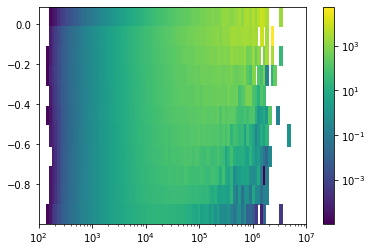

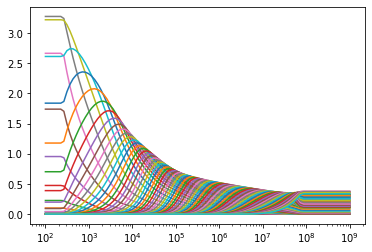

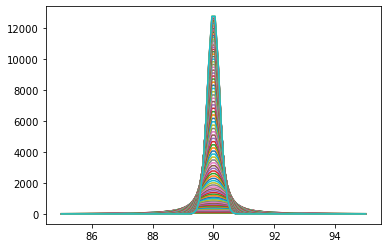

In [10]:
plt.pcolormesh(e_true, np.cos(np.pi - thetas), fit.extract()["eff_area"].squeeze().T,
              norm=LogNorm())
plt.colorbar()
plt.semilogx()
plt.figure()
_ =plt.plot(e_reco, np.exp(fit.extract()["e_res"].squeeze()))
plt.semilogx()

plt.figure()
_ =plt.plot(np.degrees(reco_zeniths), np.exp(fit.extract()["ang_res"].squeeze()).T)

In [42]:
e_true_name = "e_trues"
true_dir_name = "true_dirs"


with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        array_length_e = ForwardVariableDef("nE", "int")
        array_length_z = ForwardVariableDef("nZ", "int")
        array_length_str_e = ["[", array_length_e, "]"]
        array_length_str_z = ["[", array_length_z, "]"]
        
        e_trues = ForwardArrayDef(e_true_name, "real", array_length_str_e)
        true_dirs = ForwardArrayDef(true_dir_name, "vector[3]", array_length_str_z)


    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        array_length_2d_str = ["[", array_length_e, ",", array_length_z, "]"]
        
        eff_area_result = ForwardArrayDef("eff_area", "real", array_length_2d_str)
        
        with ForLoopContext(1, array_length_e, "i") as i:
            with ForLoopContext(1, array_length_z, "j") as j:
                eff_area_result[i][j] << ntd.effective_area(e_trues[i], true_dirs[j])       
    model = cg.generate()
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

In [ ]:
with h5py.File("../dev/statistical_model/4_tracks_and_cascades/aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    tE_bin_edges = f['2010/nu_mu/bin_edges_0'][:] # True Energy [GeV]
    cosz_bin_edges = f['2010/nu_mu/bin_edges_1'][:] # cos(zenith)
    rE_bin_edges = f['2010/nu_mu/bin_edges_2'][:] # Reco Energy [GeV]
    
tE_binc = 0.5*(tE_bin_edges[:-1]+tE_bin_edges[1:])
rE_binc = 0.5*(rE_bin_edges[:-1]+rE_bin_edges[1:])
cosz_binc = 0.5*(cosz_bin_edges[:-1]+cosz_bin_edges[1:])

In [49]:
e_true = tE_binc 
thetas = np.pi - np.arccos(cosz_binc)
true_dir = np.asarray([np.sin(thetas), np.zeros_like(thetas), np.cos(thetas)]).T

data = {
    e_true_name: e_true,
    true_dir_name: true_dir,
    "nE": len(tE_binc),
    "nZ": len(cosz_binc)
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")


[]

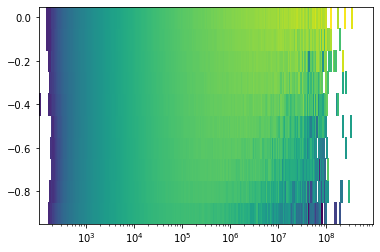

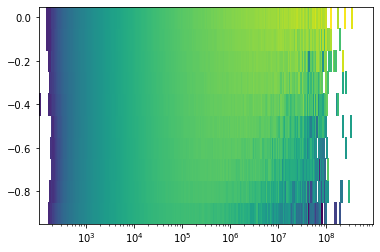

In [54]:
plt.pcolormesh(e_true, np.cos(np.pi - thetas), fit.extract()["eff_area"].squeeze().T,
              norm=LogNorm())
plt.semilogx()
plt.figure()
plt.pcolormesh(tE_binc, cosz_binc, area10.sum(axis=2).T,
               norm=LogNorm())
plt.semilogx()

In [ ]:


fig, axs = plt.subplots(1, 1, figsize=(12, 5))
cmesh = axs.pcolormesh(tE_binc, cosz_binc, area10.sum(axis=2).T,

In [14]:
ang_res_e = np.exp(fit.extract()["ang_res"].squeeze())
obs = hv.HoloMap({np.log10(e_true[i]): hv.Curve((np.degrees(reco_zeniths), ang_res_e[i])) for i in range(100)}, kdims='Energy')
obs

:HoloMap   [Energy]
   :Curve   [x]   (y)

In [15]:
e_res_e = np.exp(fit.extract()["e_res"].squeeze())
obs = hv.HoloMap({np.log10(e_true[i]): hv.Curve((np.log10(e_reco), e_res_e[i])) for i in range(100)}, kdims='Energy')
obs

:HoloMap   [Energy]
   :Curve   [x]   (y)

In [20]:
np.searchsorted(e_true, 1E5)

60

[]

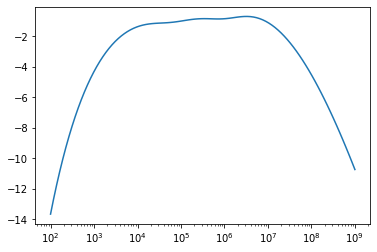

Test RV Generation
==================

In [2]:
with StanFileGenerator("stan_files/detector_model_test") as cg:   
    ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
    ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
    cg.generate_files()
    

In [54]:
with StanGenerator() as cg:
    with FunctionsContext() as fc:
        Include("utils.stan")
        Include("vMF.stan")
        #Include("detector_model_test_functions.stan")
        
    with DataContext() as dc:
        true_energy = ForwardVariableDef("true_energy", "real")
        true_dir = ForwardVariableDef("true_dir", "vector[3]")
        
    with GeneratedQuantitiesContext() as gq:
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        rec_energy = ForwardVariableDef("rec_energy", "real")
        rec_dir = ForwardVariableDef("rec_dir", "vector[3]") 
        # rec_energy_lh = ForwardVariableDef("rec_energy_lh", "real")
        # rec_dir_lh = ForwardVariableDef("rec_dir_lh", "real")
        
        rec_energy << ntd_rng.energy_resolution(true_energy)
        rec_dir << ntd_rng.angular_resolution(true_energy, true_dir)
        # rec_energy_lh << ntd_pdf.energy_resolution(true_energy, 10**rec_energy)
        # rec_dir_lh << ntd_pdf.angular_resolution(true_energy, true_dir, rec_dir)
        
    model = cg.generate()
    
    
with StanGenerator() as cg:
    with FunctionsContext() as fc:
        Include("utils.stan")
        Include("vMF.stan")
      
        
    with DataContext() as dc:
        true_energy = ForwardVariableDef("true_energy", "real")              
        e_recos = ForwardArrayDef("e_recos", "real", ["[100]"])
      
    with GeneratedQuantitiesContext() as gq:
        e_res_result = ForwardArrayDef("e_res", "real", ["[100]"])
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 
        with ForLoopContext(1, 100, "i") as i:
            e_res_result[i] << ntd_pdf.energy_resolution(true_energy, e_recos[i])
        
    model2 = cg.generate()

In [55]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[
        os.path.join(this_dir, "stan_files"),
        os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

this_dir = os.path.abspath('')
sm2 = pystan.StanModel(
    model_code=model2,
    include_paths=[
        os.path.join(this_dir, "stan_files"),
        os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

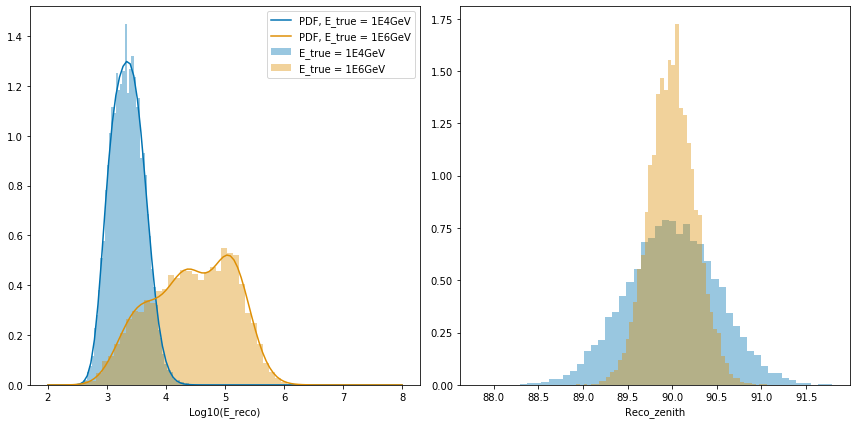

In [66]:
zenith = np.pi/2

fix, axs = plt.subplots(1, 2, figsize=(12, 6))

data = {"true_energy": 1E4,
        "true_dir":[np.sin(zenith), 0, np.cos(zenith)],
        "e_recos" : np.logspace(2, 8, 100)}

colors = sns.color_palette("colorblind")

fit = sm.sampling(data=data, iter=10000, chains=1, algorithm="Fixed_param")
fit2 = sm2.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")
sns.distplot(fit["rec_energy"], ax=axs[0], label="E_true = 1E4GeV", kde=False, norm_hist=True, color=colors[0])
sns.distplot(np.degrees(np.arccos(fit["rec_dir"][:, 2])), ax=axs[1], kde=False, norm_hist=True, color=colors[0])
axs[0].plot(np.log10(data["e_recos"]), np.exp(fit2.extract()["e_res"].squeeze()), color=colors[0], label="PDF, E_true = 1E4GeV")

data = {"true_energy": 1E6,
        "true_dir":np.asarray([np.sin(zenith), 0, np.cos(zenith)]).T,
        "e_recos" : np.logspace(2, 8, 100)}

fit = sm.sampling(data=data, iter=10000, chains=1, algorithm="Fixed_param")
fit2 = sm2.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")
sns.distplot(fit["rec_energy"], ax=axs[0], label="E_true = 1E6GeV", kde=False, norm_hist=True, color=colors[1])
sns.distplot(np.degrees(np.arccos(fit["rec_dir"][:, 2])), ax=axs[1], kde=False, norm_hist=True, color=colors[1])
axs[0].plot(np.log10(data["e_recos"]), np.exp(fit2.extract()["e_res"].squeeze()), color=colors[1], label="PDF, E_true = 1E6GeV")



axs[0].set_xlabel("Log10(E_reco)")
axs[1].set_xlabel("Reco_zenith")
axs[0].legend(loc="upper right")
plt.tight_layout()
plt.savefig("rng_crosscheck.png", dpi=200)
